In [1]:
import tensorflow as tf
tf.__version__

'2.9.0'

In [22]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import numpy as np

In [3]:
!ls ../../data/adult/

adult_processed.csv


In [4]:
data = []
path = r'../../data/adult/adult_processed.csv'
data = pd.read_csv(path)
num_col = [
    "age",
    "education-num",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
]
nonum_col = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
]
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25,4,1,7,4,7,3,2,1,0,0,40,39,0
1,38,4,11,9,2,5,0,4,1,0,0,50,39,0
2,28,2,7,12,2,11,0,4,1,0,0,40,39,1
3,44,4,15,10,2,7,0,2,1,7688,0,40,39,1
4,18,0,15,10,4,0,3,4,0,0,0,30,39,0


In [5]:
data[num_col] = data[num_col].astype(int)
for i in num_col:
    data[i] = MinMaxScaler(feature_range=[0,1]).fit_transform(data[i].values.reshape(-1, 1))
for i in nonum_col:
    data = pd.concat((data,pd.get_dummies(data[i])),axis=1)
    del data[i]
data.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,target,0,1,2,3,...,32,33,34,35,36,37,38,39,40,41
0,0.109589,0.400000,0.000000,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.287671,0.533333,0.000000,0.0,0.500000,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.150685,0.733333,0.000000,0.0,0.397959,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0.369863,0.600000,0.076881,0.0,0.397959,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.013699,0.600000,0.000000,0.0,0.295918,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
train,test = train_test_split(data,test_size=0.3,random_state=10)

In [7]:
feature = train.columns.tolist()
feature.remove('target')
label = ['target']

In [23]:
def interacting_layer(x,head_num):
    dim = x.shape[-1]
    attention_output_dim = dim*x.shape[-2]
    Q = tf.keras.layers.Dense(units=head_num*dim)(x)
    K = tf.keras.layers.Dense(units=head_num*dim)(x)
    V = tf.keras.layers.Dense(units=head_num*dim)(x)
    Qs = tf.split(Q,head_num*[dim],-1)
    Ks = tf.split(K,head_num*[dim],-1)
    Vs = tf.split(V,head_num*[dim],-1)
    alphas = []
    for num in range(head_num):
        score = tf.nn.softmax(tf.matmul(Qs[num],Ks[num],transpose_b=True)/np.sqrt(dim))
        alpha = tf.matmul(score,Vs[num])
        alpha = tf.keras.layers.Flatten()(alpha)
        alphas.append(alpha)
    attention_output = tf.keras.layers.concatenate(alphas)
    attention_output = tf.keras.layers.Dense(units=attention_output_dim)(attention_output)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=x.shape[-1])(x)
    interact_layer_output = tf.keras.layers.Activation('relu')(tf.keras.layers.add([attention_output,x]))
    return interact_layer_output

# 一层AutoInt

In [24]:
inputs = tf.keras.Input(shape=(train[feature].shape[-1],))
x = tf.keras.layers.Embedding(2,4)(inputs)
x = interacting_layer(x,4)
output = tf.keras.layers.Dense(units=1,activation='sigmoid')(x)
autoint = tf.keras.Model(inputs,output)

In [25]:
autoint.compile(optimizer=tf.keras.optimizers.Adam(1e-2),loss=tf.keras.losses.binary_crossentropy)

In [26]:
autoint_his = autoint.fit(train[feature].values,train[label].values,batch_size=100,epochs=10)

Epoch 1/10
342/342 [==============================] - 15s 39ms/step - loss: 0.4843
Epoch 2/10
342/342 [==============================] - 13s 38ms/step - loss: 0.3647
Epoch 3/10
342/342 [==============================] - 13s 38ms/step - loss: 0.3595
Epoch 4/10
342/342 [==============================] - 13s 38ms/step - loss: 0.3583
Epoch 5/10
342/342 [==============================] - 13s 38ms/step - loss: 0.3575
Epoch 6/10
342/342 [==============================] - 13s 38ms/step - loss: 0.3585
Epoch 7/10
342/342 [==============================] - 13s 38ms/step - loss: 0.3593
Epoch 8/10
342/342 [==============================] - 13s 38ms/step - loss: 0.3612
Epoch 9/10
342/342 [==============================] - 13s 39ms/step - loss: 0.3645
Epoch 10/10
342/342 [==============================] - 13s 38ms/step - loss: 0.3574


# 两层AutoInt

In [27]:
inputs = tf.keras.Input(shape=(train[feature].shape[-1],))
x = tf.keras.layers.Embedding(2,4)(inputs)
x_dim,y_dim = x.shape[1],x.shape[-1]
for i in range(1):
    x = interacting_layer(x,4)
    x = tf.keras.layers.Reshape((x_dim,y_dim))(x)
x = interacting_layer(x,4)
output = tf.keras.layers.Dense(units=1,activation='sigmoid')(x)
autoint2 = tf.keras.Model(inputs,output)

In [28]:
autoint2.compile(optimizer=tf.keras.optimizers.Adam(1e-2),loss=tf.keras.losses.binary_crossentropy)
autoint2_his = autoint2.fit(train[feature].values,train[label].values,batch_size=100,epochs=10)

Epoch 1/10
342/342 [==============================] - 27s 73ms/step - loss: 0.7056
Epoch 2/10
342/342 [==============================] - 25s 74ms/step - loss: 0.3684
Epoch 3/10
342/342 [==============================] - 25s 73ms/step - loss: 0.3666
Epoch 4/10
342/342 [==============================] - 25s 73ms/step - loss: 0.3594
Epoch 5/10
342/342 [==============================] - 25s 74ms/step - loss: 0.3597
Epoch 6/10
342/342 [==============================] - 25s 73ms/step - loss: 0.3579
Epoch 7/10
342/342 [==============================] - 25s 73ms/step - loss: 0.3590
Epoch 8/10
342/342 [==============================] - 25s 73ms/step - loss: 0.3787
Epoch 9/10
342/342 [==============================] - 25s 73ms/step - loss: 0.3647
Epoch 10/10
342/342 [==============================] - 25s 73ms/step - loss: 0.3558


# wide&AutoInt

In [29]:
hot_col = [i for i in data.columns if i not in num_col+[label]]

num_inputs = tf.keras.Input(shape=(train[num_col].shape[-1],))
hot_inputs = tf.keras.Input(shape=(train[hot_col].shape[-1],))
wide_output = tf.keras.layers.Dense(units=30)(num_inputs)
x = tf.keras.layers.Embedding(2,4)(hot_inputs)
autoint_output = interacting_layer(x,4)
all_output = tf.keras.layers.concatenate([wide_output,autoint_output])
output = tf.keras.layers.Dense(units=1,activation='sigmoid')(all_output)
wide_autoint = tf.keras.Model([num_inputs,hot_inputs],output)

In [30]:
wide_autoint.compile(optimizer=tf.keras.optimizers.Adam(1e-2),loss=tf.keras.losses.binary_crossentropy)
wide_autoint_his = wide_autoint.fit([train[num_col].values,train[hot_col].values],train[label].values,batch_size=100,epochs=10)

Epoch 1/10
342/342 [==============================] - 14s 38ms/step - loss: 0.2275
Epoch 2/10
342/342 [==============================] - 13s 38ms/step - loss: 2.5587e-04
Epoch 3/10
342/342 [==============================] - 13s 38ms/step - loss: 7.4527e-05
Epoch 4/10
342/342 [==============================] - 13s 38ms/step - loss: 3.4038e-05
Epoch 5/10
342/342 [==============================] - 13s 38ms/step - loss: 1.8732e-05
Epoch 6/10
342/342 [==============================] - 13s 38ms/step - loss: 1.1402e-05
Epoch 7/10
342/342 [==============================] - 13s 38ms/step - loss: 7.4124e-06
Epoch 8/10
342/342 [==============================] - 13s 38ms/step - loss: 5.0013e-06
Epoch 9/10
342/342 [==============================] - 13s 38ms/step - loss: 3.4248e-06
Epoch 10/10
342/342 [==============================] - 13s 38ms/step - loss: 2.3055e-06


# 训练结果可视化

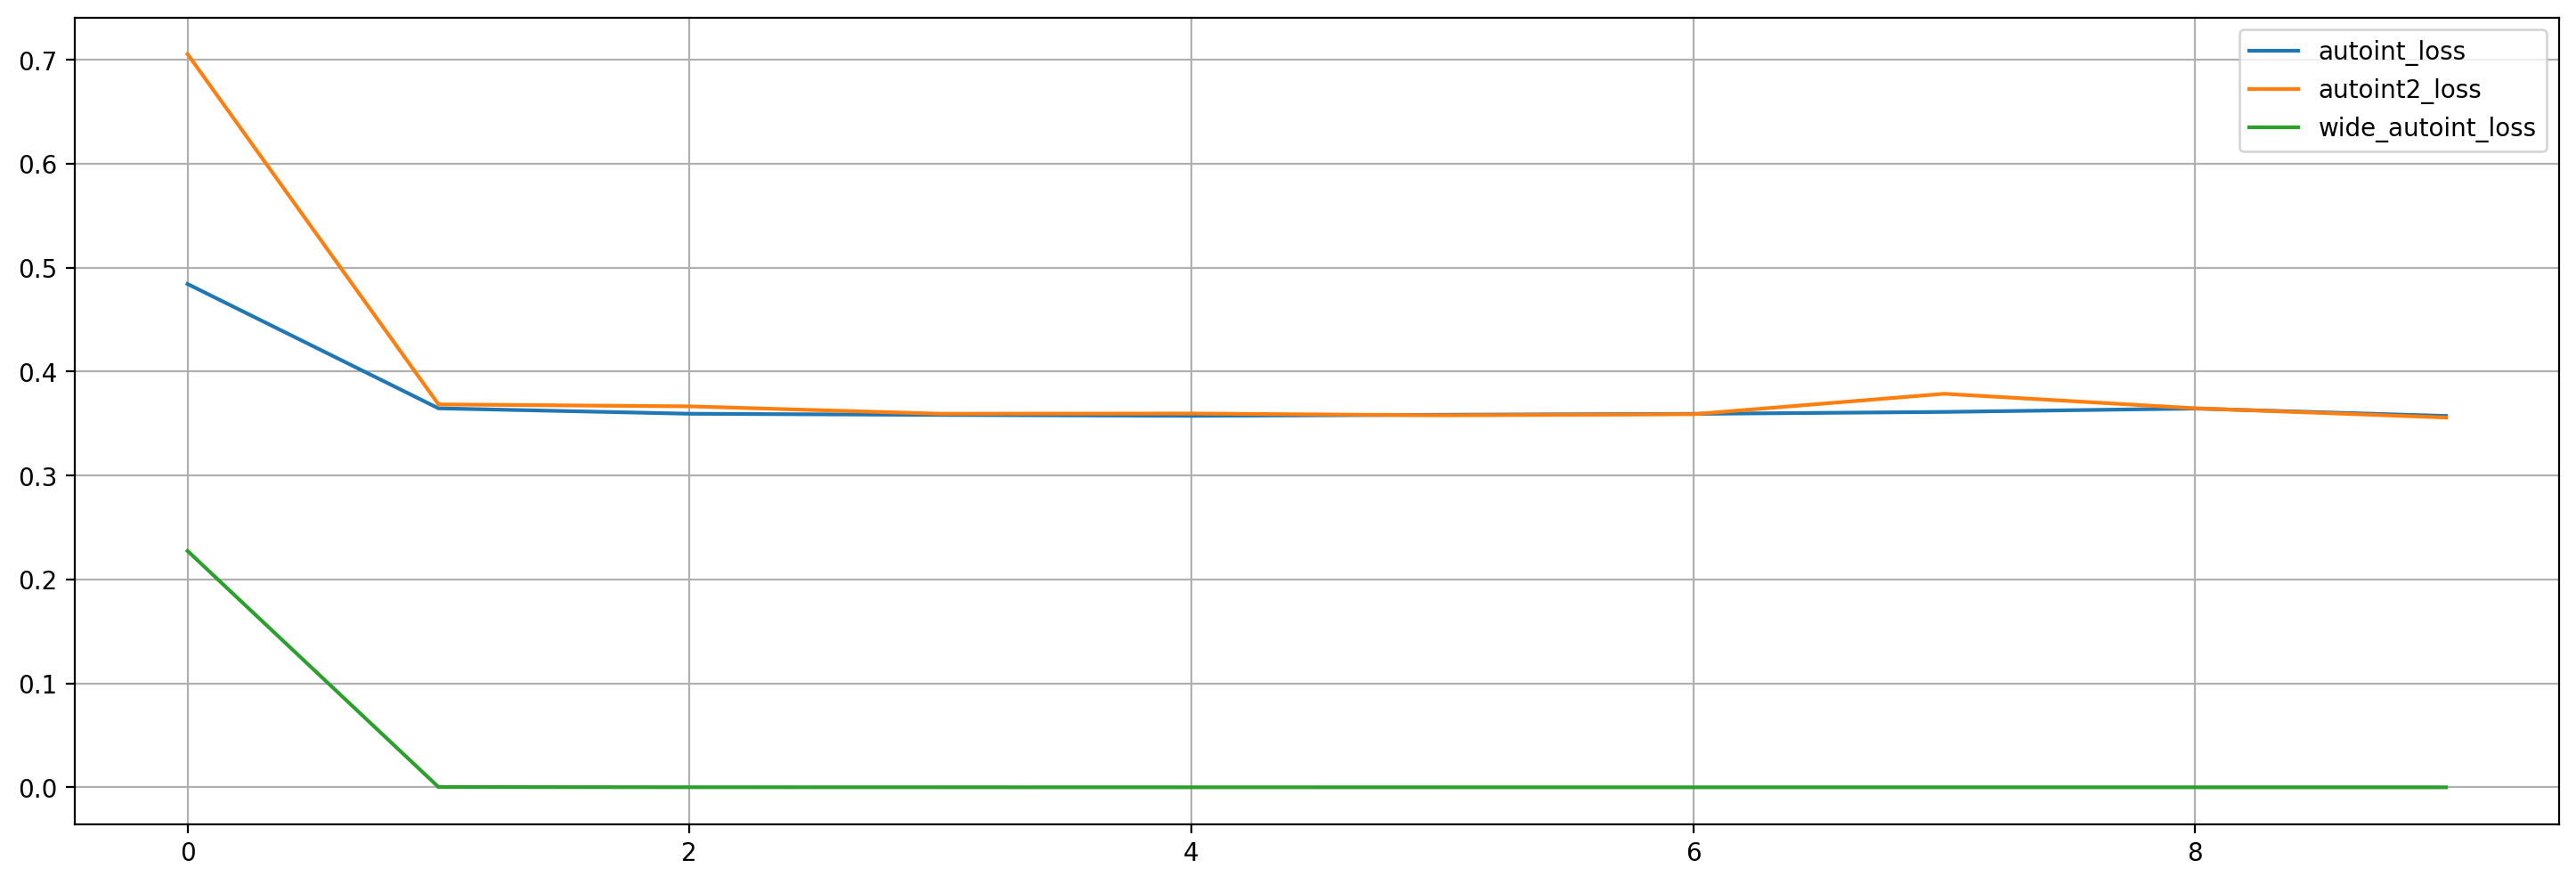

In [31]:
plt.figure(dpi=200,figsize=(18,6))
plt.plot(autoint_his.history['loss'],label='autoint_loss')
plt.plot(autoint2_his.history['loss'],label='autoint2_loss')
plt.plot(wide_autoint_his.history['loss'],label='wide_autoint_loss')
plt.legend()
plt.grid()

# 推理

In [32]:
autoint_res = list(map(lambda x:1 if x>=0.5 else 0,autoint.predict(test[feature].values).reshape(1,-1)[0]))
autoint2_res = list(map(lambda x:1 if x>=0.5 else 0,autoint2.predict(test[feature].values).reshape(1,-1)[0]))
wide_autoint_res = list(map(lambda x:1 if x>=0.5 else 0,wide_autoint.predict([test[num_col].values,test[hot_col].values]).reshape(1,-1)[0]))

458/458 [==============================] - 3s 6ms/step


In [33]:
print(classification_report(test[label],autoint_res))
print(classification_report(test[label],autoint2_res))
print(classification_report(test[label],wide_autoint_res))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     11127
           1       0.67      0.56      0.61      3526

    accuracy                           0.83     14653
   macro avg       0.77      0.74      0.75     14653
weighted avg       0.82      0.83      0.82     14653

              precision    recall  f1-score   support

           0       0.86      0.92      0.89     11127
           1       0.68      0.54      0.60      3526

    accuracy                           0.83     14653
   macro avg       0.77      0.73      0.75     14653
weighted avg       0.82      0.83      0.82     14653

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11127
           1       1.00      1.00      1.00      3526

    accuracy                           1.00     14653
   macro avg       1.00      1.00      1.00     14653
weighted avg       1.00      1.00      1.00     14653



<AxesSubplot:title={'center':'wide_autoint_res'}>

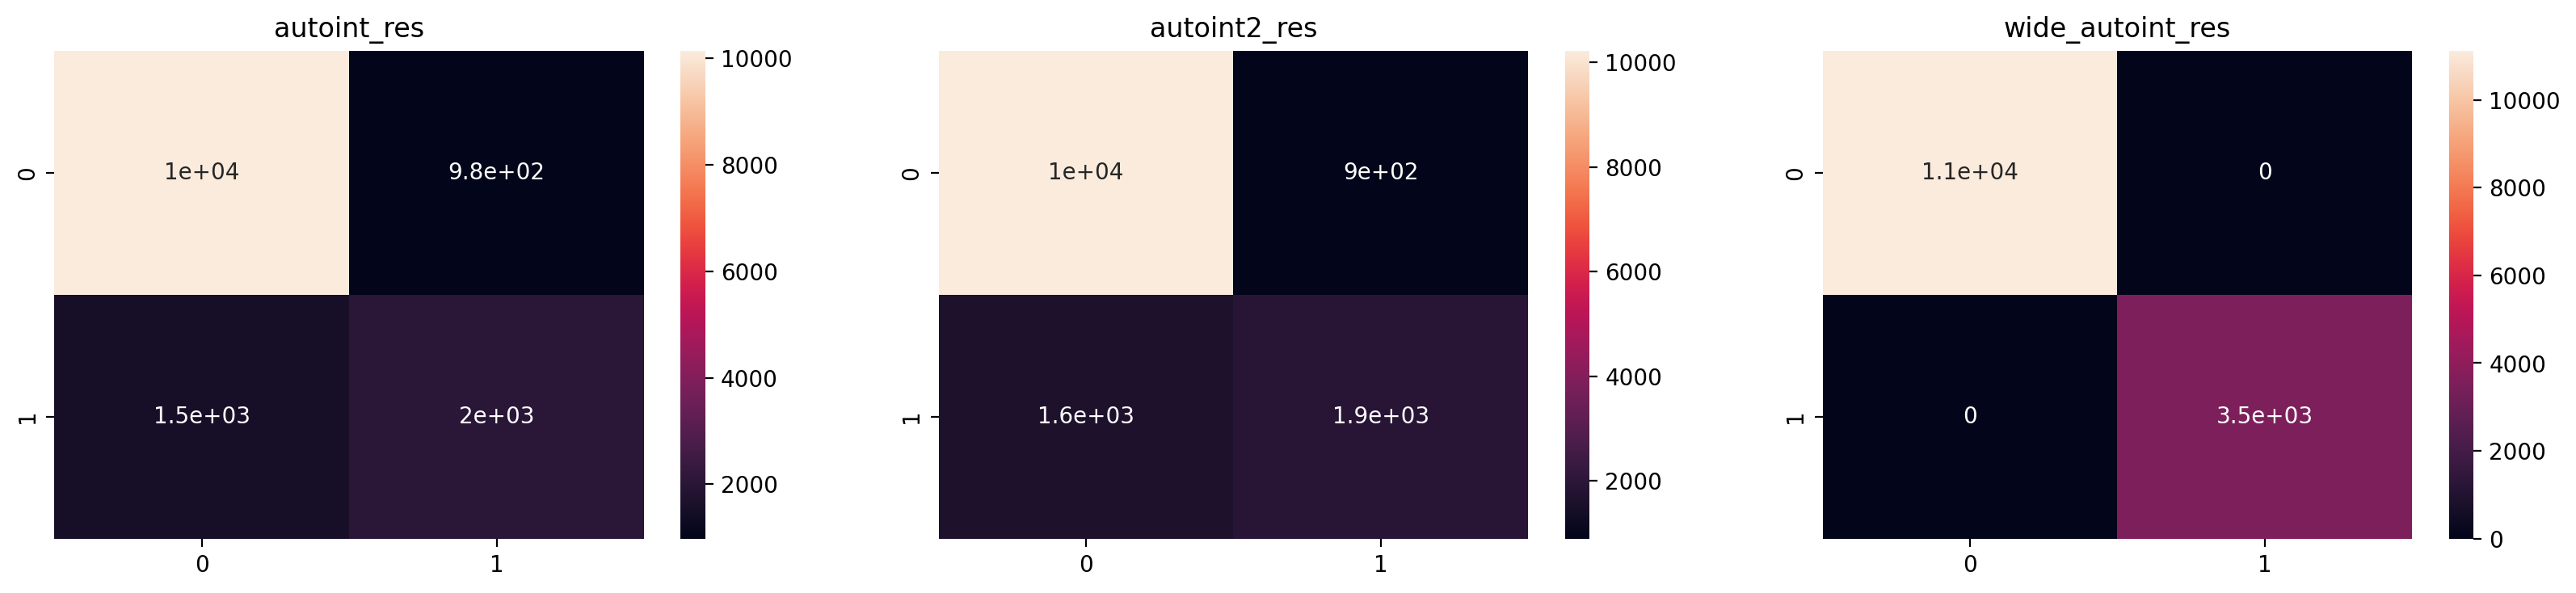

In [34]:
plt.figure(dpi=200,figsize=(20,4))
plt.subplot(131)
plt.title('autoint_res')
sns.heatmap(confusion_matrix(test[label],autoint_res),annot=True)
plt.subplot(132)
plt.title('autoint2_res')
sns.heatmap(confusion_matrix(test[label],autoint2_res),annot=True)
plt.subplot(133)
plt.title('wide_autoint_res')
sns.heatmap(confusion_matrix(test[label],wide_autoint_res),annot=True)